This example quantifies the effect of back-reaction.

# Import Modules

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

#Current Working Directory
import os
cwd = os.getcwd()

from pathlib import Path

In [2]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10,10]

import numpy as np

import darkhistory.physics as phys
import darkhistory.utilities as utils
import darkhistory.spec.pppc as pppc

from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra


from tqdm import tqdm_notebook as tqdm

import main


****** Loading transfer functions... ******
    for high-energy photons...   Done!
    for low-energy photons...  Done!
    for low-energy electrons...  Done!
    for high-energy deposition...  Done!
    for total upscattered CMB energy...  Done!
    for inverse Compton (Thomson)...  Done!
    for inverse Compton (relativistic)...  Done!
    for inverse Compton (energy loss)...  Done!
****** All transfer functions loaded! ******


In [ ]:
struct_boost = phys.struct_boost_func('einasto_with_subs')

## $\chi \chi \to \bar{b} b$

In [ ]:

withDM_noBR = main.evolve(
    
    coarsen_factor=32, std_soln=True,
    reion_switch=False,
    struct_boost=struct_boost,
    ics_only=False, separate_higheng=True, CMB_subtracted=True,
    user=None, verbose=False, 
    use_tqdm=True
)

In [92]:
noDM = main.evolve(
    elec_spec_init*0, phot_spec_init*0,
    rate_func_N, rate_func_eng, end_rs,
#     highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
#     highengdep_interp, CMB_engloss_interp,
#     ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
    coarsen_factor=coarsen_factor, std_soln=True,
    reion_switch=False,
    struct_boost=struct_boost,
    ics_only=False, separate_higheng=True, CMB_subtracted=True,
    user=None, verbose=False, 
    use_tqdm=True
)

In [93]:
withDM_BR = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, end_rs,
#     highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
#     highengdep_interp, CMB_engloss_interp,
#     ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
    coarsen_factor=coarsen_factor, std_soln=False,
    reion_switch=False,
    struct_boost=None,
    ics_only=False, separate_higheng=True, CMB_subtracted=True,
    use_tqdm=True
)

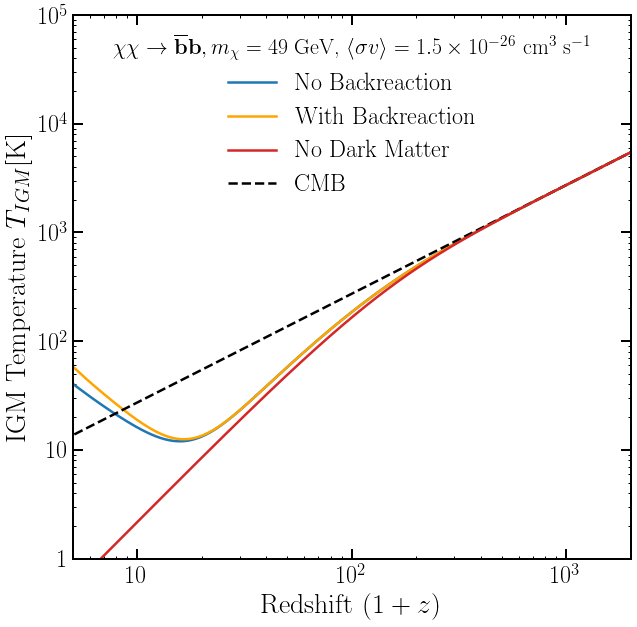

In [94]:
plt.figure()
ax = plt.gca()
ax.loglog()

plt.xlabel('Redshift $(1+z)$')
plt.ylabel('IGM Temperature $T_{IGM}$[K]')

rs_list = withDM_noBR[3].rs[:-1]

plt.axis([5, 2e3, 1, 1e5])
# plt.axvline(5.8, color='gray', linestyle='--', alpha=0.3)

plot_noBR, = plt.plot(rs_list, withDM_noBR[1][:]/phys.kB, label='No Backreaction', color='C0')
plot_BR, = plt.plot(rs_list, withDM_BR[1][:]/phys.kB, label='With Backreaction', color='orange')
plot_CMB, = plt.plot(rs_list, phys.TCMB(rs_list)/phys.kB, label='CMB', color='k', linestyle='--')
plot_std, = plt.plot(rs_list, noDM[1][:]/phys.kB, label='No Dark Matter', color='C3')

legend = plt.legend(handles=[plot_noBR, plot_BR, plot_std, plot_CMB], loc=9,
           frameon=False, title='$\mathbf{\chi\chi \\rightarrow \overline{b}b}, m_\chi = 49$ GeV,'+
                    ' $\langle \sigma v \\rangle = 1.5 \\times 10^{-26}$ cm$^3$ s$^{-1}$')
legend.get_title().set_fontsize('22')

# plt.savefig('/Users/'+user+'/Dropbox (MIT)/Photon Deposition/Draft/plots/bb_bar_swave_T.png')

-The above is an example of what inputs need to be put in the code (back-reaction, structure formation, input spectra)

-Fix the normalization

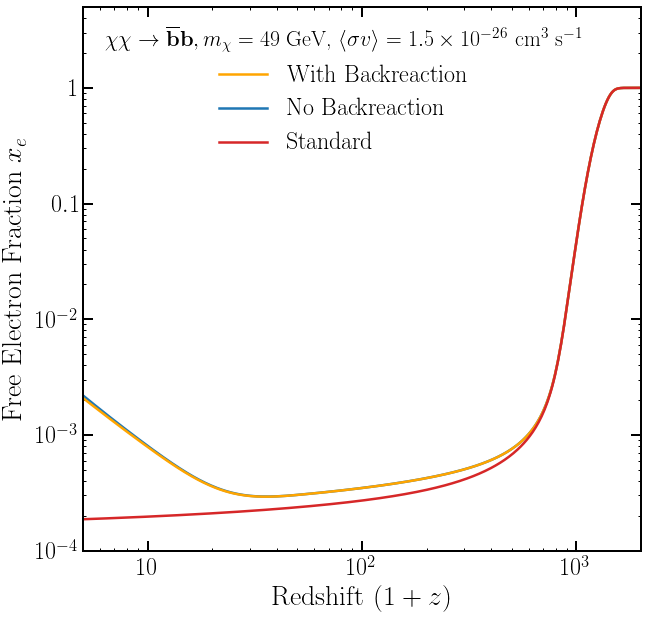

In [42]:
plt.figure()
ax = plt.gca()
ax.loglog()

plt.xlabel('Redshift $(1+z)$')
plt.ylabel('Free Electron Fraction $x_e$')

plt.axis([5, 2e3, 1e-4, 5])
# plt.axvline(7, color='gray', linestyle='--', alpha=0.3)

plot_noBR, = plt.plot(rs_list, withDM_noBR[0][:,0], label='No Backreaction', color='C0')
plot_BR, = plt.plot(rs_list, withDM_BR[0][:,0], label='With Backreaction', color='orange')
plot_std, = plt.plot(rs_list, noDM[0][:,0], label='Standard', color='C3')

legend = plt.legend(handles=[plot_BR, plot_noBR, plot_std], loc=0, 
           frameon=False, title='$\mathbf{\chi\chi \\rightarrow \overline{b}b}, m_\chi = 49$ GeV,'+
                    ' $\langle \sigma v \\rangle = 1.5 \\times 10^{-26}$ cm$^3$ s$^{-1}$')
legend.get_title().set_fontsize('22')

# plt.savefig('/Users/'+user+'/Dropbox (MIT)/Photon Deposition/Draft/plots/bb_bar_swave_xe.png')